In [1]:
import yfinance as yf
import keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM,Dropout, BatchNormalization, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.rmsprop import RMSprop
import talib

In [2]:
data = yf.download('0500.hk',"2017-09-28","2021-09-24")
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-09-28,1.47,1.50,1.47,1.49,1.49,400000
2017-09-29,1.47,1.53,1.47,1.50,1.50,929000
2017-10-03,1.60,1.68,1.58,1.68,1.68,5182471
2017-10-04,1.68,1.72,1.68,1.71,1.71,5341000
2017-10-06,1.71,1.71,1.64,1.69,1.69,1975189


In [3]:
data.shift(1).head(90)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-09-28,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-29,1.47,1.50,1.47,1.49,1.49,400000.0
2017-10-03,1.47,1.53,1.47,1.50,1.50,929000.0
2017-10-04,1.60,1.68,1.58,1.68,1.68,5182471.0
2017-10-06,1.68,1.72,1.68,1.71,1.71,5341000.0
...,...,...,...,...,...,...
2018-02-01,1.66,1.79,1.63,1.72,1.72,18453282.0
2018-02-02,1.72,1.72,1.65,1.69,1.69,2604942.0
2018-02-05,1.67,1.69,1.61,1.62,1.62,2440023.0


In [4]:
data['H-L'] = data['High'] - data['Low']
data['O-C'] = data['Close'] - data['Open']
# data=pd.merge(data,data["Close"].pct_change(),left_index=True,right_index=True)
data["% Change"]=data["Close"].shift(1).pct_change()
data['3day MA'] = data['Close'].shift(1).rolling(window = 3).mean()
data['10day MA'] = data['Close'].shift(1).rolling(window = 10).mean()
data['30day MA'] = data['Close'].shift(1).rolling(window = 30).mean()
data['Std_dev']= data['Close'].shift(1).rolling(5).std()
# data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 9)
# data['Williams %R'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 7)
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'H-L', 'O-C',
       '% Change', '3day MA', '10day MA', '30day MA', 'Std_dev'],
      dtype='object')

In [5]:
data_options = pd.read_csv("Put_Call_Ratio.csv",skiprows=1)
data_options.columns

Index(['Date (D/M/Y)', ' Call Volume', ' Put Volume', ' Put/Call Ratio'], dtype='object')

In [6]:
data_options['Date (D/M/Y)']=pd.to_datetime(data_options['Date (D/M/Y)'], format="%d/%m/%Y")
data_options.set_index('Date (D/M/Y)',inplace=True)
data_options.sort_index(ascending=True,inplace=True)
data_options.columns

Index([' Call Volume', ' Put Volume', ' Put/Call Ratio'], dtype='object')

In [7]:
# data=pd.merge(data,data_options[" Put/Call Ratio"], left_index=True,right_index=True)
data=data
# data.drop(["Volume","Adj Close"], axis=1,inplace=True)

In [8]:
data.dropna(inplace=True)
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
H-L          0
O-C          0
% Change     0
3day MA      0
10day MA     0
30day MA     0
Std_dev      0
dtype: int64

In [9]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,H-L,O-C,% Change,3day MA,10day MA,30day MA,Std_dev
Date,,,,,,,,,,,,,
2017-11-13,1.47,1.49,1.43,1.44,1.44,2505282,0.06,-0.03,-0.050955,1.556667,1.625,1.617000,0.060992
2017-11-14,1.44,1.48,1.39,1.39,1.39,2236000,0.09,-0.05,-0.033557,1.500000,1.605,1.615333,0.080747
2017-11-15,1.39,1.39,1.28,1.29,1.29,3077000,0.11,-0.10,-0.034722,1.440000,1.577,1.611667,0.090554
2017-11-16,1.30,1.32,1.24,1.27,1.27,2694753,0.08,-0.03,-0.071942,1.373333,1.537,1.598667,0.105262
2017-11-17,1.29,1.34,1.28,1.32,1.32,836376,0.06,0.03,-0.015504,1.316667,1.499,1.584000,0.094763


In [10]:
def trim_dataset(mat, batch_size):
    
    #trims dataset to a size that's divisible by BATCH_SIZE
    no_of_rows_drop = mat.shape[0] % batch_size

    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat
    
def build_timeseries(mat, y_col_index):
    
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]

    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))

    print("Length of inputs", dim_0)

    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]

    print("length of time-series - inputs", x.shape)
    print("length of time-series - outputs", y.shape)

    return x, y

train_cols = ["Open","High","Low","Close","Adj Close","Volume"]
params = {
    "batch_size": 4,  # 20<16<10, 25 was a bust
    "epochs": 1000,
    "lr": 0.00010000,
    "time_steps": 10
}
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
df_train, df_test = train_test_split(data, train_size=0.8, test_size=0.2, shuffle=False)
print("Train--Test size", len(df_train), len(df_test))
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
X_test = min_max_scaler.transform(df_test.loc[:,train_cols])
X_train, y_train = build_timeseries(x_train, 3)
X_train = trim_dataset(X_train, BATCH_SIZE)
y_train = trim_dataset(y_train, BATCH_SIZE)
x_temp, y_temp = build_timeseries(X_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)
# print(x_test.shape)
print("Batch trimmed size", X_train.shape, y_train.shape)

Train--Test size 762 191
Length of inputs 752
length of time-series - inputs (752, 10, 6)
length of time-series - outputs (752,)
Length of inputs 181
length of time-series - inputs (181, 10, 6)
length of time-series - outputs (181,)
Batch trimmed size (752, 10, 6) (752,)


/opt/homebrew/Caskroom/miniforge/base/envs/FYP/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [11]:
def create_lstm_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, X_train.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0,
                        stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
#     lstm_model.add(Dropout(0.2))

    lstm_model.add(LSTM(1, dropout=0.0))
#     lstm_model.add(Dropout(0.2))
    
#     lstm_model.add(Dense(32))
    lstm_model.add(Dense(1))
        
    #compile the model
    optimizer = Adam(lr=params["lr"])
    lstm_model.compile(loss="MSE", optimizer=optimizer)
  
    return lstm_model

lstm_model = None
lstm_model = create_lstm_model()
print(lstm_model.summary())

Metal device set to: Apple M1 Pro


2021-12-14 15:28:43.882870: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-14 15:28:43.883058: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (4, 10, 100)              42800     
                                                                 
 lstm_1 (LSTM)               (4, 1)                    408       
                                                                 
 dense (Dense)               (4, 1)                    2         
                                                                 
Total params: 43,210
Trainable params: 43,210
Non-trainable params: 0
_________________________________________________________________
None


/opt/homebrew/Caskroom/miniforge/base/envs/FYP/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=40, min_delta=0.0001)
history = lstm_model.fit(X_train, y_train, epochs=params["epochs"], batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)))

2021-12-14 15:28:44.741199: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/1000


2021-12-14 15:28:45.905347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-14 15:28:46.182316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-14 15:28:46.828022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-14 15:28:47.951129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-14 15:28:49.666388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


186/188 [============================>.] - ETA: 0s - loss: 0.1271

2021-12-14 15:28:54.965181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-14 15:28:55.120078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-14 15:28:55.178363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


188/188 [==============================] - 11s 27ms/step - loss: 0.1258 - val_loss: 0.0044
Epoch 2/1000
188/188 [==============================] - 4s 23ms/step - loss: 0.0128 - val_loss: 0.0051
Epoch 3/1000
188/188 [==============================] - 4s 23ms/step - loss: 0.0210 - val_loss: 0.0053
Epoch 4/1000
188/188 [==============================] - 4s 24ms/step - loss: 0.0224 - val_loss: 0.0055
Epoch 5/1000
188/188 [==============================] - 4s 23ms/step - loss: 0.0234 - val_loss: 0.0054
Epoch 6/1000
188/188 [==============================] - 4s 20ms/step - loss: 0.0225 - val_loss: 0.0051
Epoch 7/1000
188/188 [==============================] - 3s 18ms/step - loss: 0.0211 - val_loss: 0.0049
Epoch 8/1000
188/188 [==============================] - 4s 20ms/step - loss: 0.0196 - val_loss: 0.0047
Epoch 9/1000
188/188 [==============================] - 4s 19ms/step - loss: 0.0183 - val_loss: 0.0045
Epoch 10/1000
188/188 [==============================] - 3s 18ms/step - loss: 0.0171 

Epoch 80/1000
188/188 [==============================] - 3s 14ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 81/1000
188/188 [==============================] - 3s 16ms/step - loss: 0.0010 - val_loss: 7.5345e-04
Epoch 82/1000
188/188 [==============================] - 3s 16ms/step - loss: 0.0013 - val_loss: 7.7808e-04
Epoch 83/1000
188/188 [==============================] - 3s 14ms/step - loss: 0.0012 - val_loss: 7.8600e-04
Epoch 84/1000
188/188 [==============================] - 3s 14ms/step - loss: 0.0011 - val_loss: 7.8564e-04
Epoch 85/1000
188/188 [==============================] - 3s 16ms/step - loss: 0.0010 - val_loss: 7.8573e-04
Epoch 86/1000
188/188 [==============================] - 3s 14ms/step - loss: 0.0010 - val_loss: 7.9058e-04
Epoch 87/1000
188/188 [==============================] - 3s 14ms/step - loss: 0.0010 - val_loss: 8.0211e-04
Epoch 88/1000
188/188 [==============================] - 3s 16ms/step - loss: 0.0010 - val_loss: 8.2188e-04
Epoch 89/1000
188/188 [=========

Epoch 158/1000
188/188 [==============================] - 3s 17ms/step - loss: 0.0058 - val_loss: 0.0040
Epoch 159/1000
188/188 [==============================] - 3s 18ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 160/1000
188/188 [==============================] - 3s 16ms/step - loss: 0.0024 - val_loss: 0.0056
Epoch 161/1000
188/188 [==============================] - 3s 14ms/step - loss: 0.0029 - val_loss: 0.0065
Epoch 162/1000
188/188 [==============================] - 3s 17ms/step - loss: 0.0019 - val_loss: 0.0053
Epoch 163/1000
188/188 [==============================] - 3s 14ms/step - loss: 0.0017 - val_loss: 0.0044
Epoch 164/1000
188/188 [==============================] - 3s 14ms/step - loss: 0.0018 - val_loss: 0.0053
Epoch 165/1000
188/188 [==============================] - 3s 14ms/step - loss: 0.0016 - val_loss: 0.0054
Epoch 166/1000
188/188 [==============================] - 3s 15ms/step - loss: 0.0016 - val_loss: 0.0043
Epoch 167/1000
188/188 [==============================]

Epoch 236/1000
188/188 [==============================] - 3s 16ms/step - loss: 0.0016 - val_loss: 0.0040
Epoch 237/1000
188/188 [==============================] - 3s 15ms/step - loss: 0.0015 - val_loss: 0.0038
Epoch 238/1000
188/188 [==============================] - 3s 14ms/step - loss: 0.0015 - val_loss: 0.0070
Epoch 239/1000
188/188 [==============================] - 3s 14ms/step - loss: 0.0012 - val_loss: 0.0076
Epoch 240/1000
188/188 [==============================] - 3s 15ms/step - loss: 0.0012 - val_loss: 0.0042
Epoch 241/1000
188/188 [==============================] - 3s 15ms/step - loss: 0.0012 - val_loss: 0.0043
Epoch 242/1000
188/188 [==============================] - 3s 15ms/step - loss: 0.0011 - val_loss: 0.0066
Epoch 243/1000
188/188 [==============================] - 3s 15ms/step - loss: 0.0010 - val_loss: 0.0030
Epoch 244/1000
188/188 [==============================] - 3s 15ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 245/1000
188/188 [==============================]

188/188 [==============================] - 3s 15ms/step - loss: 7.6405e-04 - val_loss: 0.0026
Epoch 314/1000
188/188 [==============================] - 3s 14ms/step - loss: 7.4511e-04 - val_loss: 0.0027
Epoch 315/1000
188/188 [==============================] - 3s 17ms/step - loss: 7.2685e-04 - val_loss: 0.0028
Epoch 316/1000
188/188 [==============================] - 3s 15ms/step - loss: 7.1258e-04 - val_loss: 0.0024
Epoch 317/1000
188/188 [==============================] - 3s 15ms/step - loss: 7.5323e-04 - val_loss: 0.0042
Epoch 318/1000
188/188 [==============================] - 3s 15ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 319/1000
188/188 [==============================] - 3s 15ms/step - loss: 0.0022 - val_loss: 0.0044
Epoch 320/1000
188/188 [==============================] - 4s 19ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 321/1000
188/188 [==============================] - 3s 16ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 322/1000
188/188 [==========================

188/188 [==============================] - 3s 14ms/step - loss: 7.3406e-04 - val_loss: 0.0046
Epoch 391/1000
188/188 [==============================] - 3s 14ms/step - loss: 9.2485e-04 - val_loss: 0.0017
Epoch 392/1000
188/188 [==============================] - 3s 14ms/step - loss: 0.0012 - val_loss: 0.0073
Epoch 393/1000
188/188 [==============================] - 3s 14ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 394/1000
188/188 [==============================] - 3s 14ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 395/1000
188/188 [==============================] - 3s 14ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 396/1000
188/188 [==============================] - 3s 14ms/step - loss: 0.0011 - val_loss: 0.0045
Epoch 397/1000
188/188 [==============================] - 3s 14ms/step - loss: 9.8940e-04 - val_loss: 0.0037
Epoch 398/1000
188/188 [==============================] - 3s 14ms/step - loss: 9.4491e-04 - val_loss: 0.0029
Epoch 399/1000
188/188 [==============================

188/188 [==============================] - 3s 15ms/step - loss: 7.9605e-04 - val_loss: 0.0018
Epoch 467/1000
188/188 [==============================] - 3s 15ms/step - loss: 6.8545e-04 - val_loss: 0.0017
Epoch 468/1000
188/188 [==============================] - 3s 16ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 469/1000
188/188 [==============================] - 3s 15ms/step - loss: 8.9941e-04 - val_loss: 0.0013
Epoch 470/1000
188/188 [==============================] - 3s 15ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 471/1000
188/188 [==============================] - 3s 15ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 472/1000
188/188 [==============================] - 3s 14ms/step - loss: 0.0018 - val_loss: 0.0030
Epoch 473/1000
188/188 [==============================] - 3s 14ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 474/1000
188/188 [==============================] - 3s 14ms/step - loss: 9.4593e-04 - val_loss: 0.0019
Epoch 475/1000
188/188 [==============================

188/188 [==============================] - 3s 15ms/step - loss: 0.0011 - val_loss: 0.0025
Epoch 543/1000
188/188 [==============================] - 3s 15ms/step - loss: 0.0010 - val_loss: 0.0016
Epoch 544/1000
188/188 [==============================] - 3s 14ms/step - loss: 8.9328e-04 - val_loss: 0.0019
Epoch 545/1000
188/188 [==============================] - 3s 15ms/step - loss: 9.4728e-04 - val_loss: 0.0020
Epoch 546/1000
188/188 [==============================] - 3s 14ms/step - loss: 9.3229e-04 - val_loss: 0.0019
Epoch 547/1000
188/188 [==============================] - 3s 14ms/step - loss: 8.6236e-04 - val_loss: 0.0019
Epoch 548/1000
188/188 [==============================] - 3s 14ms/step - loss: 8.9611e-04 - val_loss: 0.0018
Epoch 549/1000
188/188 [==============================] - 3s 14ms/step - loss: 9.1799e-04 - val_loss: 0.0022
Epoch 550/1000
188/188 [==============================] - 3s 14ms/step - loss: 9.6031e-04 - val_loss: 0.0024
Epoch 551/1000
188/188 [==================

188/188 [==============================] - 3s 16ms/step - loss: 6.3802e-04 - val_loss: 0.0017
Epoch 619/1000
188/188 [==============================] - 3s 15ms/step - loss: 6.2483e-04 - val_loss: 0.0016
Epoch 620/1000
188/188 [==============================] - 3s 16ms/step - loss: 6.0793e-04 - val_loss: 0.0018
Epoch 621/1000
188/188 [==============================] - 3s 16ms/step - loss: 5.8250e-04 - val_loss: 0.0015
Epoch 622/1000
188/188 [==============================] - 3s 15ms/step - loss: 5.8953e-04 - val_loss: 0.0017
Epoch 623/1000
188/188 [==============================] - 3s 14ms/step - loss: 5.7931e-04 - val_loss: 0.0016
Epoch 624/1000
188/188 [==============================] - 3s 15ms/step - loss: 6.0274e-04 - val_loss: 0.0014
Epoch 625/1000
188/188 [==============================] - 3s 14ms/step - loss: 5.7803e-04 - val_loss: 0.0016
Epoch 626/1000
188/188 [==============================] - 3s 16ms/step - loss: 6.0719e-04 - val_loss: 0.0030
Epoch 627/1000
188/188 [==========

Epoch 694/1000
188/188 [==============================] - 3s 15ms/step - loss: 0.0010 - val_loss: 0.0027
Epoch 695/1000
188/188 [==============================] - 3s 15ms/step - loss: 9.2564e-04 - val_loss: 0.0027
Epoch 696/1000
188/188 [==============================] - 3s 16ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 697/1000
188/188 [==============================] - 3s 15ms/step - loss: 0.0010 - val_loss: 0.0043
Epoch 698/1000
188/188 [==============================] - 3s 14ms/step - loss: 0.0011 - val_loss: 0.0051
Epoch 699/1000
188/188 [==============================] - 3s 14ms/step - loss: 0.0012 - val_loss: 0.0038
Epoch 700/1000
188/188 [==============================] - 3s 15ms/step - loss: 0.0013 - val_loss: 0.0038
Epoch 701/1000
188/188 [==============================] - 3s 15ms/step - loss: 0.0010 - val_loss: 0.0054
Epoch 702/1000
188/188 [==============================] - 3s 14ms/step - loss: 9.2163e-04 - val_loss: 0.0032
Epoch 703/1000
188/188 [=======================

188/188 [==============================] - 3s 17ms/step - loss: 7.0413e-04 - val_loss: 0.0022
Epoch 771/1000
188/188 [==============================] - 3s 15ms/step - loss: 7.1257e-04 - val_loss: 0.0021
Epoch 772/1000
188/188 [==============================] - 3s 16ms/step - loss: 7.5550e-04 - val_loss: 0.0022
Epoch 773/1000
188/188 [==============================] - 3s 15ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 774/1000
188/188 [==============================] - 3s 15ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 775/1000
188/188 [==============================] - 3s 16ms/step - loss: 8.3091e-04 - val_loss: 0.0017
Epoch 776/1000
188/188 [==============================] - 3s 14ms/step - loss: 8.1209e-04 - val_loss: 0.0010
Epoch 777/1000
188/188 [==============================] - 3s 14ms/step - loss: 8.4506e-04 - val_loss: 0.0014
Epoch 778/1000
188/188 [==============================] - 3s 15ms/step - loss: 7.8276e-04 - val_loss: 0.0021
Epoch 779/1000
188/188 [==================

188/188 [==============================] - 3s 15ms/step - loss: 9.1658e-04 - val_loss: 0.0020
Epoch 846/1000
188/188 [==============================] - 3s 15ms/step - loss: 9.4618e-04 - val_loss: 0.0025
Epoch 847/1000
188/188 [==============================] - 3s 15ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 848/1000
188/188 [==============================] - 3s 15ms/step - loss: 8.7020e-04 - val_loss: 0.0046
Epoch 849/1000
188/188 [==============================] - 3s 14ms/step - loss: 8.0111e-04 - val_loss: 0.0030
Epoch 850/1000
188/188 [==============================] - 3s 15ms/step - loss: 7.6185e-04 - val_loss: 0.0034
Epoch 851/1000
188/188 [==============================] - 3s 14ms/step - loss: 8.7936e-04 - val_loss: 0.0021
Epoch 852/1000
188/188 [==============================] - 3s 15ms/step - loss: 7.0423e-04 - val_loss: 0.0025
Epoch 853/1000
188/188 [==============================] - 3s 14ms/step - loss: 7.7358e-04 - val_loss: 0.0025
Epoch 854/1000
188/188 [==============

188/188 [==============================] - 3s 14ms/step - loss: 6.2000e-04 - val_loss: 0.0017
Epoch 920/1000
188/188 [==============================] - 3s 14ms/step - loss: 6.4277e-04 - val_loss: 8.0541e-04
Epoch 921/1000
188/188 [==============================] - 3s 14ms/step - loss: 8.7858e-04 - val_loss: 9.5884e-04
Epoch 922/1000
188/188 [==============================] - 3s 14ms/step - loss: 9.8630e-04 - val_loss: 9.3616e-04
Epoch 923/1000
188/188 [==============================] - 3s 14ms/step - loss: 9.1105e-04 - val_loss: 8.9878e-04
Epoch 924/1000
188/188 [==============================] - 3s 14ms/step - loss: 8.9983e-04 - val_loss: 8.4157e-04
Epoch 925/1000
188/188 [==============================] - 3s 14ms/step - loss: 7.8063e-04 - val_loss: 7.0521e-04
Epoch 926/1000
188/188 [==============================] - 3s 14ms/step - loss: 8.2390e-04 - val_loss: 8.4407e-04
Epoch 927/1000
188/188 [==============================] - 3s 15ms/step - loss: 8.2959e-04 - val_loss: 6.9399e-04
Ep

188/188 [==============================] - 2s 13ms/step - loss: 7.7623e-04 - val_loss: 0.0025
Epoch 994/1000
188/188 [==============================] - 2s 12ms/step - loss: 9.5145e-04 - val_loss: 0.0022
Epoch 995/1000
188/188 [==============================] - 3s 17ms/step - loss: 7.9842e-04 - val_loss: 0.0014
Epoch 996/1000
188/188 [==============================] - 4s 20ms/step - loss: 6.3276e-04 - val_loss: 0.0030
Epoch 997/1000
188/188 [==============================] - 4s 20ms/step - loss: 7.0498e-04 - val_loss: 0.0019
Epoch 998/1000
188/188 [==============================] - 4s 21ms/step - loss: 7.0124e-04 - val_loss: 0.0034
Epoch 999/1000
188/188 [==============================] - 4s 23ms/step - loss: 7.8705e-04 - val_loss: 0.0034
Epoch 1000/1000
188/188 [==============================] - 4s 20ms/step - loss: 8.9908e-04 - val_loss: 0.0036


In [13]:
y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

2021-12-14 16:16:58.123723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-14 16:16:58.260744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-14 16:16:58.354189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Error is 0.0014686385294609755 (88,) (88,)
[0.28380027 0.3047194  0.3108907  0.31068984 0.3132493  0.34347388
 0.38582274 0.3713802  0.32992896 0.33950943 0.32026696 0.32203707
 0.32868063 0.32920122 0.3439246 ]
[0.36873156 0.37463126 0.38053096 0.35693217 0.35693217 0.35693217
 0.35693217 0.35103243 0.35693217 0.35103243 0.36283187 0.35103243
 0.35693217 0.38053096 0.37463126]
[0.78604144 0.82149935 0.8319597  0.83161926 0.8359575  0.8871882
 0.95896953 0.9344894  0.86422956 0.8804685  0.84785247 0.85085285
 0.86211365 0.86299604 0.8879522 ]
[0.93000001 0.94       0.94999999 0.91000003 0.91000003 0.91000003
 0.91000003 0.89999998 0.91000003 0.89999998 0.92000002 0.89999998
 0.91000003 0.94999999 0.94      ]


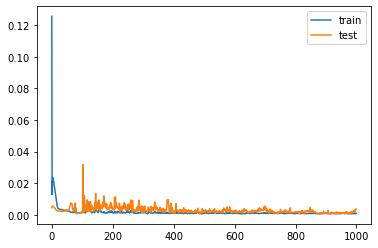

In [14]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [23]:
from sklearn.metrics import accuracy_score
y_pred_lstm_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)

print(y_pred_lstm_org[0:15])
print(y_test_t_org[0:15])

[0.78604144 0.82149935 0.8319597  0.83161926 0.8359575  0.8871882
 0.95896953 0.9344894  0.86422956 0.8804685  0.84785247 0.85085285
 0.86211365 0.86299604 0.8879522 ]
[0.625      0.63499999 0.64499998 0.60500002 0.60500002 0.60500002
 0.60500002 0.59499997 0.60500002 0.59499997 0.61500001 0.59499997
 0.60500002 0.64499998 0.63499999]


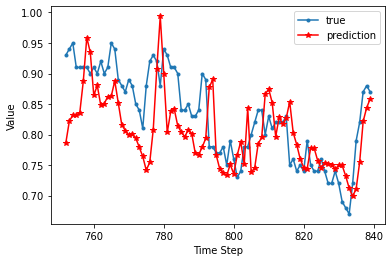

In [17]:
# plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test_t_org)), y_test_t_org, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test_t_org)), y_pred_org, 'r',marker='*' ,label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [18]:
y_pred_lstm_final = np.zeros((len(y_pred)-1,))
y_test_t_final = np.zeros((len(y_test_t)-1,))
for i in range(len(y_pred)-1):
    if y_pred[i+1] >= y_pred[i]:
        y_pred_lstm_final[i] = 1
    else:
        y_pred_lstm_final[i] = 0
        
#convert prediction into binary output (up or down movement)
for i in range(len(y_test_t)-1):
    if y_test_t[i+1] >= y_test_t[i]:
        y_test_t_final[i] = 1
    else:
        y_test_t_final[i] = 0


# error_lstm = mean_absolute_error(y_test_t_final, y_pred_lstm_final)
# print("Error is", error_lstm, y_pred_lstm_final.shape, y_test_t_final.shape)
print(y_pred_lstm_final[0:15])
print(y_test_t_final[0:15])
print("Predicted direction accuracy (Up/down):")
print(accuracy_score(y_test_t_final,y_pred_lstm_final))

[1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0.]
[1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0.]
Predicted direction accuracy (Up/down):
0.5632183908045977


In [19]:
data['y_pred'] = np.NaN
data.iloc[(len(data) - len(y_pred)):,-1:] = y_pred_org
data.dropna()

,Open,High,Low,Close,Adj Close,Volume,H-L,O-C,% Change,3day MA,10day MA,30day MA,Std_dev,y_pred
Date,,,,,,,,,,,,,,
2021-05-20,0.87,0.94,0.86,0.91,0.91,2541225,0.08,0.04,0.010638,0.940000,0.944,0.807667,0.008367,0.786041
2021-05-21,0.90,0.91,0.86,0.91,0.91,770188,0.05,0.01,-0.042105,0.933333,0.940,0.819667,0.014832,0.821499
2021-05-24,0.87,0.91,0.87,0.91,0.91,417188,0.04,0.04,0.000000,0.923333,0.932,0.832333,0.017889,0.831960
2021-05-25,0.91,0.91,0.88,0.91,0.91,517000,0.03,0.00,0.000000,0.910000,0.929,0.844333,0.019494,0.831619
2021-05-26,0.91,0.92,0.87,0.90,0.90,476000,0.05,-0.01,0.000000,0.910000,0.926,0.856000,0.017889,0.835958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-16,0.88,0.89,0.84,0.88,0.88,1003000,0.05,0.00,0.060976,0.826667,0.742,0.765667,0.079561,0.710951
2021-09-17,0.89,0.89,0.84,0.87,0.87,1138000,0.05,-0.02,0.011494,0.856667,0.758,0.767000,0.065038,0.754849
2021-09-20,0.87,0.90,0.81,0.86,0.86,6735000,0.09,-0.01,-0.011364,0.873333,0.771,0.769333,0.039115,0.821554


In [ ]:
mean_absolute_percentage_error(y_pred_org,y_test_t_org)*100

In [ ]:
mean_squared_error(y_pred_org,y_test_t_org)